In [108]:
#Importing the necessary libraries
import numpy as np
import re
import pandas as pd
import string
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [109]:
#reading the data file
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [110]:
#Checking the missing values 
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [111]:
#Distribution of the target coulmn
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

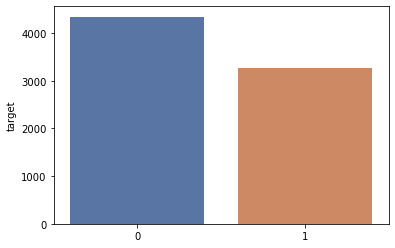

In [112]:
#Plot to view the target distribution 
sb.barplot(df['target'].value_counts().index,df['target'].value_counts(),palette='deep')

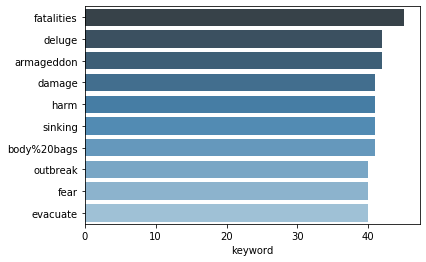

In [113]:
#Plot to view the keyword distribution 
sb.barplot(x = df['keyword'].value_counts()[:10], y = df['keyword'].value_counts()[:10].index, orient = 'h', palette = 'Blues_d') 

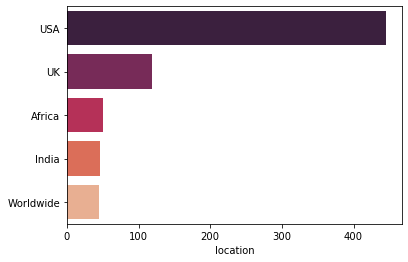

In [114]:
#Replacing the missing values of the Location column to plot the same

df['location'].replace({   "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":'India',
                           "United States":'USA',
                          'New York':'USA'}, inplace = True)




sb.barplot(x = df['location'].value_counts()[:5], y = df['location'].value_counts()[:5].index, orient = 'h', palette = 'rocket') 

In [115]:
# Checking the disaster related and unrelated tweets
related_tweets = df[df['target']==1]['text']
#related_tweets.values[1]

unrelated_tweets = df[df['target']==0]['text']
#unrelated_tweets.values[1]


In [116]:
#dropping the unwanted column data and converting the text into lowercase
dropped_columns = df.drop(columns=['keyword','location'])
dropped_columns['text'] = dropped_columns['text'].str.lower()

In [117]:
#function to remove punctuation from the text column 
def eliminate_punctuation(column):
    return column.translate(str.maketrans("","", string.punctuation))
dropped_columns['text'].apply(lambda text: eliminate_punctuation(text))


0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609                                                 name
7610    m194 0104 utc5km s of volcano hawaii httptcozd...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [118]:
#function to get rid of special characters, digits and URLs
def preprocess(column):
    temp = column
    temp = re.sub('\n', " ", temp)
    temp =re.sub('\'', "", temp)
    temp = re.sub('-', " ", temp)
    temp = re.sub('#'," ", temp)
    temp = re.sub(r"(http|https|pic.)\S+"," ",temp)
    temp = re.sub(r'[^\w\s]',' ',temp)
    temp = re.sub("(\d+)","",temp)
    #print("this is the cleaned text", temp)
    return temp

dropped_columns['text'] =  dropped_columns['text'].apply(lambda text:preprocess(text))

In [119]:
dropped_columns['text']

0       our deeds are the reason of this  earthquake m...
1                  forest fire near la ronge sask  canada
2       all residents asked to shelter in place are be...
3         people receive  wildfires evacuation orders ...
4       just got sent this photo from ruby  alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609                                                name 
7610                 m     utc  km s of volcano hawaii   
7611    police investigating after an e bike collided ...
7612    the latest  more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

In [120]:
#Stopwords removal 
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer 
STOPWORDS = set(stopwords.words('english'))

In [121]:
def remove_stopwords(column):
    return ' '.join([word for word in column.split() if word not in (STOPWORDS)])

In [122]:
dropped_columns['text'] = dropped_columns['text'].apply(lambda text: remove_stopwords(text))

In [123]:
dropped_columns.head()

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders cal...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1


In [124]:
#Tokenization
import nltk
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
dropped_columns['text'] = dropped_columns['text'].apply(lambda x: tokenizer.tokenize(x))
# test_df['text'] = test_df['text'].apply(lambda x: tokenizer.tokenize(x))
dropped_columns['text'].head()




0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [125]:
#Stemming and Lemmatization to remove and replace the words with their root form 
from nltk.stem import PorterStemmer
ps = PorterStemmer()
def stemmer(column):
    return ([ps.stem(word)for word in column])

dropped_columns['text'] = dropped_columns['text'].apply(lambda text: stemmer(text))

In [126]:
dropped_columns['text'].head()


0    [deed, reason, earthquak, may, allah, forgiv, us]
1         [forest, fire, near, la, rong, sask, canada]
2    [resid, ask, shelter, place, notifi, offic, ev...
3    [peopl, receiv, wildfir, evacu, order, califor...
4    [got, sent, photo, rubi, alaska, smoke, wildfi...
Name: text, dtype: object

In [127]:
from nltk.stem import WordNetLemmatizer

root_word = WordNetLemmatizer()
def lemmatizer(column):
    return ([root_word.lemmatize(word) for word in column])
dropped_columns['text'] = dropped_columns['text'].apply(lambda text: lemmatizer(text))

In [128]:
dropped_columns['text'].head()

0     [deed, reason, earthquak, may, allah, forgiv, u]
1         [forest, fire, near, la, rong, sask, canada]
2    [resid, ask, shelter, place, notifi, offic, ev...
3    [peopl, receiv, wildfir, evacu, order, califor...
4    [got, sent, photo, rubi, alaska, smoke, wildfi...
Name: text, dtype: object

In [129]:
dropped_columns['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [130]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

dropped_columns['text'] = dropped_columns['text'].apply(lambda x : combine_text(x))

In [131]:
dropped_columns['text'].head()

0             deed reason earthquak may allah forgiv u
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

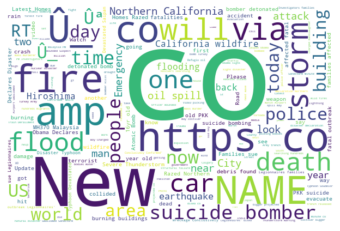

In [132]:
#Worldcloud representation to check the most frequently used words 
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Start with one review:
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(related_tweets))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [133]:
#Converting the collection of text into a matrix of token counts
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(dropped_columns['text'])
test_vectors = count_vectorizer.transform(test_df["text"])

## Keeping only non-zero elements to preserve space 
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


In [134]:
#Implementation to check the frequency of the words(also how rare) in the text 
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(dropped_columns['text'])
test_tfidf = tfidf.transform(test_df["text"])

In [135]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, dropped_columns["target"], cv=5, scoring="f1")
scores

array([0.59765625, 0.55361596, 0.60903427, 0.5490566 , 0.71428571])

In [136]:
# Fitting a simple Naive Bayes on TFIDF
from sklearn.naive_bayes import MultinomialNB
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, dropped_columns["target"], cv=5, scoring="f1")
scores

array([0.5890411 , 0.59607173, 0.62956811, 0.59168242, 0.73941368])